# Voronoi - scipy

In [4]:
from random import randint, choice, random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import os
import math

## Load image as matrix

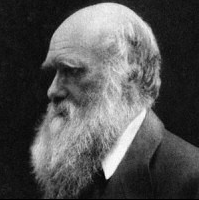

In [7]:
darwin = Image.open("images/darwin.png").convert("RGB")
darwin

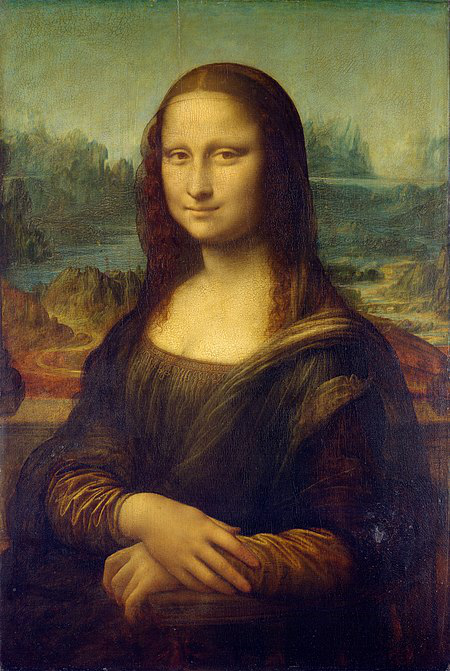

In [8]:
mona = Image.open("images/mona_lisa.jpg").convert("RGB")
mona

In [9]:
img_dar = np.array(darwin)
img_mona = np.array(mona)

In [10]:
def get_bounds_voronoi(nr_points, size, rgb_range = [0,255]):
    
    w_range = [1, size[0]]
    h_range = [1, size[1]]

    point = 3*[rgb_range] + [w_range, h_range]  # R; G, B, x, y
    bounds = nr_points*point

    return bounds

In [11]:
def popul_from_bounds_voronoi(bounds, popsize, nr_params = 5):
    
    population = []
    
    nr_points = len(bounds)//nr_params  # 5 - RGB and then X,Y
    
    for i in range(0, popsize):
        indv = []

        for j in range(nr_points):
            point = []
            for k in range(nr_params):
                point.append(randint(bounds[k][0],bounds[k][1]))
            indv.append(point)
        population.append(indv)
        
    return population

In [12]:
vor_pop

NameError: name 'vor_pop' is not defined

In [13]:
## NOTE this function copied from - stackoverflow - https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        if p1 in all_ridges:  # Check if key in dictionary (previously got error)
            ridges = all_ridges[p1]
        else:
            continue
            
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [14]:
# Generates image from Voronoi
    #size - image height and width
    #vor_data - list of voronoi data, in shape [[R,G,B,,X,Y],[..],..] 
    
def gen_image_voronoi(size, vor_data):

    points = [x[3:] for x in vor_data] # X,Y 
    colors = [x[:3] for x in vor_data] # [(R,G,B),..]
    
    # Calculate voronoi diagram based on points
    vor = Voronoi(points)
    regions, vertices = voronoi_finite_polygons_2d(vor)
    
    # Split into X and Y
    X = [coord[0] for coord in vertices]
    Y = [coord[1] for coord in vertices]
    # Get padding for X and Y
    pad_x = abs(math.floor(min(X)))
    pad_y = abs(math.floor(min(Y)))
    # Normalize the data, so it starts from 0
    X = np.array([X - min(X)])
    Y = np.array([Y - min(Y)])
    # Back to vertices
    vertices = np.concatenate((X.T,Y.T), axis=1)
    size_new = (math.ceil(max(X[0])), math.ceil(max(Y[0])))
    
    image = Image.new("RGB", size_new, (255,255,255,0)) 
    draw = ImageDraw.Draw(image, mode="RGBA")
    
    for i, region in enumerate(regions):       
        new_color = tuple(colors[i])
        polygon = vertices[region] 
        polygon = tuple(map(tuple, polygon))
        draw.polygon(polygon, fill= new_color)
        
    img_mat = np.array(image)

    del image
    del draw
    
    return img_mat[pad_y:size[1]+pad_y, pad_x:size[0]+pad_x]

In [15]:
# Cost function for using polygons
    # orig_mat - original image given as matrix
    # nr_points - number of points used
    # params - information about voronoi data in 1-D array (R,G,B,x,y)

def cost_voronoi(params, orig_mat, nr_points):
    
    vor_data = np.split(params, nr_points)
    size = tuple(reversed(orig_mat.shape[:2])) # W and H of image
    
    new_mat = gen_image_voronoi(size, vor_data)
        
    return square_error(orig_mat, new_mat)

In [16]:
# Calculates square error between two images
    #img1, img2 - images in array with shape (w,h,3)
def square_error(img1, img2):
    return np.sum(np.square(img1.astype("int64") - img2.astype("int64")))

In [22]:
# Show image generated base on dna
    # size - tuple - size of the image
    # dna - voronoi parameters for generating image
    # nr - how many points used
def show_img(size, dna, nr):
    new_img = gen_image_voronoi(size, np.split(dna, nr))
    plt.imshow(new_img)
    plt.show()
    
# Similar to show_img, but saves instead of showing
    # size - tuple - size of the image
    # dna - voronoi parameters for generating image
    # nr - how many points used
    # file - string - file name
def save_img(size, dna, nr, file):
    new_img = gen_image_voronoi(size, np.split(dna, nr))
    plt.imsave(file + ".png", new_img)

In [23]:
# Hill climbing function for voronoi cost function
    # img_name - path to image
    # nr_points - number of points used for voronoi diagram
    # iter - iterations done, before ending
    # mut_rate - how big steps are done (used if mut_random = FALSE)
    # mut_change - how often worsening mutation is passed through
    # save_every - how often the result is saved
    # mut_random - make random change to dna
    # path - where image is saved
    # file_name - name of file
def hill_voronoi(img_name, nr_points, iter = 10, mut_rate = 0.05, mut_chance = 0.05, \
                 save_every = 100, mut_random = False, path = "images/", file_name = "img"):
    
    #Load image
    img = Image.open(img_name).convert("RGB")
    orig_img = np.array(img)
    
    # Create dictinary
    if not os.path.exists(path):
        os.makedirs(path)
    
    file_name = path + file_name
    
    # Get params
    size = tuple(reversed(orig_img.shape[:2])) # W and H of image
    bounds = get_bounds_voronoi(nr_points=nr_points, size = size)
    
    # Init DNA
    dna = popul_from_bounds_voronoi(bounds=bounds, popsize=1)[0]  # Only one element in pop, take 1st
    dna = np.array(dna).flatten()
    
    # Calculate first cost
    cost_last = cost_voronoi(params=dna, nr_points=nr_points, orig_mat=orig_img)
        
    # Variables
    len_dna = len(dna)
    dna_last = dna
    dna_new = dna_last.copy()
    
    impr = 0
    
    # Hill climbing loop - done "iter" times
    for i in range(iter):    
        
        # Select randomly param to change and change it by mutation rate
        idx = randint(0, len_dna - 1)
        limits = bounds[idx]  # limits 
        
        if mut_random:
            # Random mutation
            dna_new[idx] = randint(limits[0], limits[1])
        else:
            #Mutate
            direction = choice([-1,1])  # Select randomly the direction
            dna_new[idx] = dna_last[idx] + direction*limits[1]*mut_rate
        
        # Quick limits check
        if dna_new[idx] > limits[1]:
            dna_new[idx] = limits[1]
        elif dna_new[idx] < limits[0]:
            dna_new[idx] = limits[0]
        
        # Calculate new cost
        cost_new = cost_voronoi(params=dna_new, nr_points=nr_points, orig_mat=orig_img)
        
        mut = random()
        
        # Compare costs
        if (mut < mut_chance)  or (cost_new < cost_last):
            dna_last = dna_new.copy()
            cost_last = cost_new
            impr += 1
        else:
            dna_new = dna_last.copy()
            
        if i % save_every == 0:
            print("Iteration", i)
            print("improvements", impr)
            fit = 100 - 100*(cost_last/(255*255*3*size[0]*size[1]))
            print("Fit: ", fit)
            #show_img(size, dna_last, nr_points)
            save_img(size, dna_last, nr_points, file_name + "_" + str(i))
            
    #show_img(size, dna_last, nr_points)
    save_img(size, dna_last, nr_points, file_name + "_" + str(i))
    return dna_last

In [24]:
hill_voronoi("images/darwin.png", nr_points = 30, iter = 10000, mut_random=True, mut_chance=-1, path="image/test/", file_name="img")

Iteration 0
improvements 0
Fit:  81.5616825767
Iteration 100
improvements 43
Fit:  89.2600736606
Iteration 200
improvements 66
Fit:  91.3143770242
Iteration 300
improvements 92
Fit:  93.8378319767


IndexError: too many indices for array

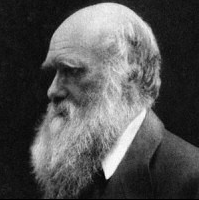

In [44]:
darwin